## License Plate Detection Model Training

### Importing necessary libraries and dependencies

In [4]:
!pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable


In [6]:
import os
import cv2
import shutil
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import xml.etree.ElementTree as xet
from sklearn.model_selection import train_test_split

In [8]:
!pip install torch

Defaulting to user installation because normal site-packages is not writeable


### Checking if GPU is available for training|

In [13]:
import torch

print(f'{torch.cuda.is_available() = }')
print(f'{torch.cuda.device_count() = }')

torch.cuda.is_available() = False
torch.cuda.device_count() = 0


In [15]:
!pip install ultralytics

Defaulting to user installation because normal site-packages is not writeable


In [17]:
!pip install -U ipywidgets

Defaulting to user installation because normal site-packages is not writeable


### Importing data

In [20]:
dataset_path = 'archive'

#### Function to extract the first sequence of digits from the given filename string

In [23]:
import re

def the_number_in_the_string(filename):
    """
    Extracts the first sequence of digits from the given filename string and returns it as an integer.
    If no digits are found, returns 0.
    """
    # Search for the first occurrence of one or more digits in the filename
    match = re.search(r'(\d+)', filename)
    
    # If a match is found, return the matched number as an integer
    if match:
        return int(match.group(0))
    # If no match is found, return 0
    else:
        return 0


In [25]:
labels_dict = dict(
    img_path=[], 
    xmin=[], 
    xmax=[], 
    ymin=[], 
    ymax=[], 
    img_w=[], 
    img_h=[]
)

In [27]:
# Get the list of XML files from the annotations directory
xml_files = glob(f'{dataset_path}/annotations/*.xml')

#### Processing each XML file

In [30]:
for filename in sorted(xml_files, key=the_number_in_the_string):
    # Parse the XML file
    info = xet.parse(filename)
    root = info.getroot()
    
    # Find the 'object' element in the XML and extract bounding box information
    member_object = root.find('object')
    labels_info = member_object.find('bndbox')
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)
    
    # Get the image filename and construct the full path to the image
    img_name = root.find('filename').text
    img_path = os.path.join(dataset_path, 'images', img_name)

    # Append the extracted information to the respective lists in the dictionary
    labels_dict['img_path'].append(img_path)
    labels_dict['xmin'].append(xmin)
    labels_dict['xmax'].append(xmax)
    labels_dict['ymin'].append(ymin)
    labels_dict['ymax'].append(ymax)
    
    # Read the image to get its dimensions
    height, width, _ = cv2.imread(img_path).shape
    labels_dict['img_w'].append(width)
    labels_dict['img_h'].append(height)
    
# Convert the dictionary to a pandas DataFrame
alldata = pd.DataFrame(labels_dict)

# Display the DataFrame
alldata

,img_path,xmin,xmax,ymin,ymax,img_w,img_h
0,archive\images\Cars0.png,226,419,125,173,500,268
1,archive\images\Cars1.png,134,262,128,160,400,248
2,archive\images\Cars2.png,229,270,176,193,400,400
3,archive\images\Cars3.png,142,261,128,157,400,225
4,archive\images\Cars4.png,156,503,82,253,590,350
...,...,...,...,...,...,...,...
428,archive\images\Cars428.png,142,258,128,157,400,225
429,archive\images\Cars429.png,86,208,166,195,301,400
430,archive\images\Cars430.png,38,116,159,197,400,225
431,archive\images\Cars431.png,55,343,82,147,400,192


### Train-test split

In [33]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
# Use 10% of the data for the test set
train, test = train_test_split(alldata, test_size=1/10, random_state=42)

# Split the training data further into training and validation sets
# Use 8/9 of the remaining data for the training set, resulting in an 80/10/10 split overall
train, val = train_test_split(train, train_size=8/9, random_state=42)

# Print the number of samples in each set
print(f'''
      len(train) = {len(train)}
      len(val) = {len(val)}
      len(test) = {len(test)}
''')


      len(train) = 345
      len(val) = 44
      len(test) = 44



### Preparing data for model training

In [36]:
# Remove the 'datasets' directory if it exists
if os.path.exists('datasets'):
    shutil.rmtree('datasets')

In [38]:
def make_split_folder_in_yolo_format(split_name, split_df, output_folder):
    """
    Creates a folder structure for a dataset split (train/val/test) in YOLO format.

    Parameters:
    split_name (str): The name of the split (e.g., 'train', 'val', 'test').
    split_df (pd.DataFrame): The DataFrame containing the data for the split.
    output_folder (str): The root folder where the dataset will be created.

    The function will create 'labels' and 'images' subdirectories under '{output_folder}/cars_license_plate/{split_name}',
    and save the corresponding labels and images in YOLO format.
    """
    labels_path = os.path.join(output_folder, 'cars_license_plate', split_name, 'labels')
    images_path = os.path.join(output_folder, 'cars_license_plate', split_name, 'images')

    # Create directories for labels and images
    os.makedirs(labels_path, exist_ok=True)
    os.makedirs(images_path, exist_ok=True)
    
    # Iterate over each row in the DataFrame
    for _, row in split_df.iterrows():
        img_name, img_extension = os.path.splitext(os.path.basename(row['img_path']))
        
        # Calculate YOLO format bounding box coordinates
        x_center = (row['xmin'] + row['xmax']) / 2 / row['img_w']
        y_center = (row['ymin'] + row['ymax']) / 2 / row['img_h']
        width = (row['xmax'] - row['xmin']) / row['img_w']
        height = (row['ymax'] - row['ymin']) / row['img_h']

        # Save the label in YOLO format
        label_path = os.path.join(labels_path, f'{img_name}.txt')
        with open(label_path, 'w') as file:
            file.write(f"0 {x_center:.4f} {y_center:.4f} {width:.4f} {height:.4f}\n")
            
        # Copy the image to the images directory
        shutil.copy(row['img_path'], os.path.join(images_path, img_name + img_extension))
    
    print(f"Created '{images_path}' and '{labels_path}'")

In [40]:
# Create YOLO format folders for train, validation, and test splits
make_split_folder_in_yolo_format("train", train, "datasets")
make_split_folder_in_yolo_format("val", val, "datasets")
make_split_folder_in_yolo_format("test", test, "datasets")

Created 'datasets\cars_license_plate\train\images' and 'datasets\cars_license_plate\train\labels'
Created 'datasets\cars_license_plate\val\images' and 'datasets\cars_license_plate\val\labels'
Created 'datasets\cars_license_plate\test\images' and 'datasets\cars_license_plate\test\labels'


In [42]:
# Directory paths
image_dir = 'cars_license_plate_new/train/images'
label_dir = 'cars_license_plate_new/train/labels'

In [44]:
# Get the first image file
image_files = sorted(os.listdir(image_dir))
first_image_file = image_files[0]

# Construct paths for the image and its corresponding label
image_path = os.path.join(image_dir, first_image_file)
label_path = os.path.join(label_dir, os.path.splitext(first_image_file)[0] + '.txt')

# Load the image using OpenCV
image = cv2.imread(image_path)
# Convert the image from BGR (OpenCV default) to RGB (matplotlib default)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Read the label file to get bounding box information
with open(label_path, 'r') as f:
    lines = f.readlines()

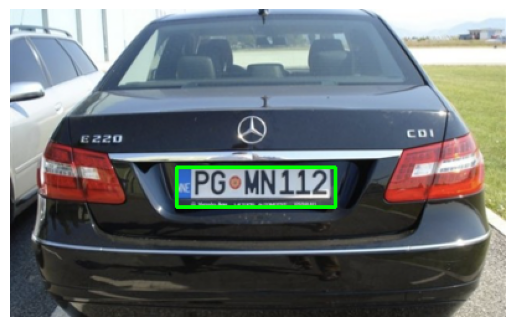

In [46]:
# Plot the bounding box on the image
for line in lines:
    # Parse the label file line to extract bounding box information
    class_id, x_center, y_center, width, height = map(float, line.strip().split())
    img_height, img_width, _ = image.shape

    # Convert YOLO format to bounding box format
    x_center *= img_width
    y_center *= img_height
    width *= img_width
    height *= img_height

    # Calculate the top-left and bottom-right coordinates of the bounding box
    x1 = int(x_center - width / 2)
    y1 = int(y_center - height / 2)
    x2 = int(x_center + width / 2)
    y2 = int(y_center + height / 2)

    # Draw the bounding box on the image using a green rectangle
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Display the image with bounding box using matplotlib
plt.imshow(image)
plt.axis('off')  # Hide the axis
plt.show()  # Display the image

In [48]:
# Define the content of the datasets.yaml file
datasets_yaml = '''
path: cars_license_plate_new

train: train/images
val: val/images
test: test/images

# number of classes
nc: 1

# class names
names: ['license_plate']
'''

# Write the content to the datasets.yaml file
with open('datasets.yaml', 'w') as file:
    file.write(datasets_yaml)

### Model Training and Evaluation

In [51]:
from ultralytics import YOLO
model = YOLO('yolov8n.pt')

100%|██████████| 6.23M/6.23M [00:03<00:00, 1.90MB/s]


In [53]:
model.train(
    data="datasets.yaml",  # Path to the dataset configuration file
    epochs=100,            # Number of training epochs
    batch=16,              # Batch size
    device='cpu',          # Use CPU for training
    imgsz=320,             # Image size (width and height) for training
    cache=True             # Cache images for faster training
)

New https://pypi.org/project/ultralytics/8.2.52 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.50  Python-3.12.3 torch-2.3.1+cpu CPU (AMD Ryzen 7 5800H with Radeon Graphics)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=datasets.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=320, save=True, save_period=-1, cache=True, device=cpu, workers=8, project=None, name=train19, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_fr

train: Scanning C:\Documents\Intel Unnati\7th Jul\cars_license_plate_new\train\labels.cache... 345 images, 0 backgrounds, 0 corrupt: 100%|██████████| 345/345 [00:00<?, ?it/s]
train: Caching images (0.1GB RAM): 100%|██████████| 345/345 [00:00<00:00, 853.42it/s]
val: Scanning C:\Documents\Intel Unnati\7th Jul\cars_license_plate_new\val\labels.cache... 44 images, 0 backgrounds, 0 corrupt: 100%|██████████| 44/44 [00:00<?, ?it/s]
val: Caching images (0.0GB RAM): 100%|██████████| 44/44 [00:00<00:00, 843.20it/s]


Plotting labels to runs\detect\train19\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 320 train, 320 val
Using 0 dataloader workers
Logging results to runs\detect\train19
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100         0G      1.594      2.786      1.257         17        320: 100%|██████████| 22/22 [00:22<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.52it/s]

                   all         44         44    0.00352      0.932      0.598       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100         0G      1.579      1.518      1.137         16        320: 100%|██████████| 22/22 [00:21<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.07it/s]

                   all         44         44    0.00463      0.886      0.272       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100         0G      1.536      1.401      1.154         15        320: 100%|██████████| 22/22 [00:21<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.97it/s]

                   all         44         44      0.677      0.295      0.317      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100         0G      1.526      1.351      1.191         18        320: 100%|██████████| 22/22 [00:21<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.06it/s]

                   all         44         44      0.733      0.561      0.706      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100         0G      1.534      1.288      1.187         18        320: 100%|██████████| 22/22 [00:21<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.09it/s]

                   all         44         44      0.679      0.568      0.629      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100         0G      1.532      1.272      1.147         21        320: 100%|██████████| 22/22 [00:21<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]

                   all         44         44      0.882      0.679      0.753      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100         0G      1.468      1.145      1.156         15        320: 100%|██████████| 22/22 [00:21<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.05it/s]

                   all         44         44      0.703      0.295      0.357      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100         0G      1.498      1.134       1.17         23        320: 100%|██████████| 22/22 [00:21<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.62it/s]

                   all         44         44      0.488      0.591      0.512      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100         0G      1.456      1.069      1.161         13        320: 100%|██████████| 22/22 [00:21<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.95it/s]

                   all         44         44      0.834      0.727      0.741      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100         0G      1.404      1.026       1.12         20        320: 100%|██████████| 22/22 [00:21<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.97it/s]

                   all         44         44      0.832      0.705       0.79      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100         0G      1.371      1.007      1.112         24        320: 100%|██████████| 22/22 [00:21<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.10it/s]

                   all         44         44      0.812      0.882      0.881      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100         0G       1.33     0.9416      1.072         21        320: 100%|██████████| 22/22 [00:22<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.03it/s]

                   all         44         44      0.892      0.795       0.89       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100         0G      1.311     0.8927      1.077         20        320: 100%|██████████| 22/22 [00:21<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.93it/s]

                   all         44         44      0.859      0.864      0.877      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100         0G      1.339     0.9124      1.065         19        320: 100%|██████████| 22/22 [00:22<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.78it/s]

                   all         44         44      0.824      0.886      0.871      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100         0G      1.322     0.9129      1.097         14        320: 100%|██████████| 22/22 [00:22<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.10it/s]

                   all         44         44      0.919      0.841      0.877      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100         0G       1.32     0.8965       1.11         15        320: 100%|██████████| 22/22 [00:22<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]

                   all         44         44      0.822      0.818       0.79      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100         0G      1.309      0.867      1.081         16        320: 100%|██████████| 22/22 [00:22<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.08it/s]

                   all         44         44      0.914      0.795      0.844      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100         0G      1.309     0.8775      1.105         15        320: 100%|██████████| 22/22 [00:21<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.10it/s]

                   all         44         44      0.846      0.871      0.866      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100         0G      1.314      0.839      1.096         15        320: 100%|██████████| 22/22 [00:21<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.13it/s]

                   all         44         44      0.916      0.886      0.883      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100         0G      1.239     0.8222      1.053         15        320: 100%|██████████| 22/22 [00:21<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.09it/s]

                   all         44         44      0.874      0.864      0.913      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100         0G      1.193     0.7636      1.034         22        320: 100%|██████████| 22/22 [00:21<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.11it/s]

                   all         44         44      0.948      0.834      0.892      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100         0G      1.184     0.7828      1.035         13        320: 100%|██████████| 22/22 [00:21<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.03it/s]

                   all         44         44      0.848      0.909       0.89       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100         0G      1.159     0.7422      1.032         21        320: 100%|██████████| 22/22 [00:21<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.96it/s]

                   all         44         44      0.872      0.841      0.884      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100         0G      1.118     0.7352      1.023         21        320: 100%|██████████| 22/22 [00:21<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.06it/s]

                   all         44         44      0.901      0.864       0.89      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100         0G      1.212     0.7647      1.035         15        320: 100%|██████████| 22/22 [00:21<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.10it/s]

                   all         44         44      0.946        0.8      0.893      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100         0G      1.165     0.7393      1.026         20        320: 100%|██████████| 22/22 [00:22<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.96it/s]

                   all         44         44      0.946      0.792      0.875      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100         0G      1.137     0.7245      1.024         12        320: 100%|██████████| 22/22 [00:22<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.95it/s]

                   all         44         44      0.929      0.795      0.864      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100         0G      1.126     0.7225      1.016         16        320: 100%|██████████| 22/22 [00:22<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.07it/s]

                   all         44         44      0.901      0.828      0.887      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100         0G      1.121     0.6994      1.002         24        320: 100%|██████████| 22/22 [00:21<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.08it/s]

                   all         44         44      0.906      0.909      0.939      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100         0G      1.093     0.6998     0.9954         16        320: 100%|██████████| 22/22 [00:21<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.09it/s]

                   all         44         44      0.885      0.909      0.895      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100         0G      1.108     0.6991      1.016         18        320: 100%|██████████| 22/22 [00:21<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.10it/s]

                   all         44         44      0.902      0.832      0.885      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100         0G      1.094     0.6919      1.004         13        320: 100%|██████████| 22/22 [00:21<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.05it/s]

                   all         44         44      0.826      0.864      0.885      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100         0G      1.079      0.686     0.9867         20        320: 100%|██████████| 22/22 [00:22<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.09it/s]

                   all         44         44      0.957      0.841       0.93      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100         0G       1.05     0.6576     0.9923         17        320: 100%|██████████| 22/22 [00:21<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.92it/s]

                   all         44         44      0.939      0.864       0.91      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100         0G      1.053     0.6701      0.975         16        320: 100%|██████████| 22/22 [00:21<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.10it/s]

                   all         44         44      0.894      0.818      0.891      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100         0G      1.081      0.667      1.002         12        320: 100%|██████████| 22/22 [00:21<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.96it/s]

                   all         44         44      0.907      0.882      0.901      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100         0G      1.092     0.6963      1.017         17        320: 100%|██████████| 22/22 [00:22<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.05it/s]

                   all         44         44      0.907      0.864      0.907      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100         0G      1.092     0.6777      1.004         18        320: 100%|██████████| 22/22 [00:23<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.74it/s]

                   all         44         44      0.965      0.886      0.919       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100         0G      1.038      0.631     0.9707         16        320: 100%|██████████| 22/22 [00:22<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.83it/s]

                   all         44         44      0.968      0.886      0.913      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100         0G      1.043     0.6512      0.979         15        320: 100%|██████████| 22/22 [00:21<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]

                   all         44         44      0.942      0.841       0.92      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100         0G      1.052     0.6469      0.986         16        320: 100%|██████████| 22/22 [00:22<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.09it/s]

                   all         44         44      0.906      0.878      0.918      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100         0G      1.018     0.6178     0.9888         20        320: 100%|██████████| 22/22 [00:21<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]

                   all         44         44      0.901      0.886      0.904      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100         0G      1.027     0.6354      1.001         14        320: 100%|██████████| 22/22 [00:21<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.11it/s]

                   all         44         44      0.864      0.909      0.921      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100         0G     0.9997     0.6243     0.9782         17        320: 100%|██████████| 22/22 [00:21<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.08it/s]

                   all         44         44      0.979      0.841      0.946      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100         0G      1.018     0.6106     0.9723         13        320: 100%|██████████| 22/22 [00:21<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.09it/s]

                   all         44         44      0.865      0.909      0.937      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100         0G      1.021     0.6275     0.9809         21        320: 100%|██████████| 22/22 [00:21<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.08it/s]

                   all         44         44      0.951      0.883      0.938      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100         0G     0.9959     0.6146     0.9574         12        320: 100%|██████████| 22/22 [00:21<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.11it/s]

                   all         44         44      0.951      0.882      0.926      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100         0G      1.032     0.6227     0.9625         17        320: 100%|██████████| 22/22 [00:21<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.07it/s]

                   all         44         44      0.846      0.932      0.937      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100         0G     0.9399     0.5842     0.9562         22        320: 100%|██████████| 22/22 [00:21<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.04it/s]

                   all         44         44       0.85      0.901      0.923      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100         0G     0.9598     0.5801     0.9622         17        320: 100%|██████████| 22/22 [00:21<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.09it/s]

                   all         44         44      0.882      0.848      0.901      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100         0G     0.9702     0.5745     0.9626         15        320: 100%|██████████| 22/22 [00:21<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.08it/s]

                   all         44         44      0.884      0.868      0.924      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100         0G     0.9914     0.5738     0.9571         16        320: 100%|██████████| 22/22 [00:21<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.09it/s]

                   all         44         44       0.88      0.886      0.923      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100         0G      0.936     0.5642     0.9431         15        320: 100%|██████████| 22/22 [00:21<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.10it/s]

                   all         44         44      0.895      0.886      0.919      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100         0G     0.9161     0.5534     0.9469         16        320: 100%|██████████| 22/22 [00:21<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.89it/s]

                   all         44         44      0.842      0.886      0.921      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100         0G     0.9298     0.5598     0.9424         16        320: 100%|██████████| 22/22 [00:21<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.09it/s]

                   all         44         44      0.925      0.843      0.929      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100         0G     0.9411     0.5534     0.9417         19        320: 100%|██████████| 22/22 [00:21<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.03it/s]

                   all         44         44       0.92      0.909       0.93      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100         0G     0.9141     0.5605     0.9548         23        320: 100%|██████████| 22/22 [00:21<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.06it/s]

                   all         44         44      0.925      0.909      0.919      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100         0G     0.9359     0.5466     0.9403         20        320: 100%|██████████| 22/22 [00:21<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.97it/s]

                   all         44         44       0.88      0.841      0.918      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100         0G     0.9207     0.5741     0.9429         17        320: 100%|██████████| 22/22 [00:21<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.10it/s]

                   all         44         44      0.917      0.818      0.918      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100         0G     0.9311     0.5448     0.9368         11        320: 100%|██████████| 22/22 [00:21<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.08it/s]

                   all         44         44      0.879      0.886      0.933      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100         0G      0.903     0.5398     0.9373         14        320: 100%|██████████| 22/22 [00:21<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.12it/s]

                   all         44         44      0.924      0.841      0.932      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100         0G      0.838     0.5165     0.9353         16        320: 100%|██████████| 22/22 [00:21<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.11it/s]

                   all         44         44      0.885      0.841      0.897      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100         0G     0.8803     0.5269     0.9325         19        320: 100%|██████████| 22/22 [00:22<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.11it/s]

                   all         44         44      0.918      0.909      0.936      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100         0G      0.888     0.5474     0.9382         13        320: 100%|██████████| 22/22 [00:21<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.07it/s]

                   all         44         44        0.9      0.886      0.927      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100         0G     0.8801     0.5419     0.9461         17        320: 100%|██████████| 22/22 [00:21<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.04it/s]

                   all         44         44      0.958      0.864      0.928      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100         0G     0.8885     0.5272     0.9353         13        320: 100%|██████████| 22/22 [00:21<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.11it/s]

                   all         44         44       0.88      0.909      0.921      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100         0G     0.8464     0.5289     0.9348         12        320: 100%|██████████| 22/22 [00:21<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  2.00it/s]

                   all         44         44       0.88      0.909      0.936      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100         0G     0.8672     0.5234      0.939         18        320: 100%|██████████| 22/22 [00:21<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.12it/s]

                   all         44         44      0.907      0.888      0.922      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100         0G     0.8536     0.5172     0.9371         16        320: 100%|██████████| 22/22 [00:21<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.12it/s]

                   all         44         44      0.888      0.909      0.924      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100         0G     0.8811     0.5273     0.9352         14        320: 100%|██████████| 22/22 [00:21<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.11it/s]

                   all         44         44      0.886      0.909      0.935      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100         0G     0.8502     0.5132     0.9182         18        320: 100%|██████████| 22/22 [00:21<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.13it/s]

                   all         44         44      0.898      0.886      0.934      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100         0G     0.8767     0.5215     0.9255         14        320: 100%|██████████| 22/22 [00:21<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.04it/s]

                   all         44         44      0.909      0.864      0.934       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100         0G      0.856     0.5127     0.9348         15        320: 100%|██████████| 22/22 [00:21<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.12it/s]

                   all         44         44      0.869      0.903      0.921      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100         0G     0.8285     0.4919     0.9155         14        320: 100%|██████████| 22/22 [00:21<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]

                   all         44         44      0.888      0.903      0.936      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100         0G     0.8196     0.5036     0.9209         19        320: 100%|██████████| 22/22 [00:21<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.09it/s]

                   all         44         44      0.908      0.901      0.941      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100         0G     0.8199     0.4919     0.9132         11        320: 100%|██████████| 22/22 [00:21<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.10it/s]

                   all         44         44      0.887      0.864      0.935      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100         0G     0.7854     0.4747     0.9139         22        320: 100%|██████████| 22/22 [00:21<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.13it/s]

                   all         44         44      0.947      0.864      0.936      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100         0G     0.8061     0.4751      0.918         16        320: 100%|██████████| 22/22 [00:21<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.12it/s]

                   all         44         44       0.95      0.859      0.938      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100         0G     0.7829     0.4806     0.9164         17        320: 100%|██████████| 22/22 [00:21<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.03it/s]

                   all         44         44      0.899      0.909      0.925      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100         0G     0.8195     0.4784       0.91         16        320: 100%|██████████| 22/22 [00:21<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.12it/s]

                   all         44         44      0.917      0.886      0.943      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100         0G     0.7762     0.4836     0.9117         17        320: 100%|██████████| 22/22 [00:21<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]

                   all         44         44      0.951      0.881      0.945      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100         0G     0.7922     0.4702     0.9113         12        320: 100%|██████████| 22/22 [00:21<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.10it/s]

                   all         44         44      0.928      0.875      0.945      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100         0G     0.7643     0.4657     0.8988         21        320: 100%|██████████| 22/22 [00:21<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.05it/s]

                   all         44         44      0.927      0.872      0.934      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100         0G     0.7421     0.4407     0.9026         19        320: 100%|██████████| 22/22 [00:21<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.11it/s]

                   all         44         44      0.927       0.87      0.942       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100         0G     0.7862     0.4687     0.9058         14        320: 100%|██████████| 22/22 [00:21<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.08it/s]

                   all         44         44      0.951      0.885      0.925      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100         0G     0.7471     0.4645     0.9049         18        320: 100%|██████████| 22/22 [00:21<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.07it/s]

                   all         44         44      0.951      0.876      0.929      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100         0G     0.7592     0.4708     0.9141         16        320: 100%|██████████| 22/22 [00:21<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.07it/s]

                   all         44         44      0.935      0.864      0.941      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100         0G     0.7433     0.4475     0.9071         16        320: 100%|██████████| 22/22 [00:21<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.98it/s]

                   all         44         44      0.948      0.864      0.943      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100         0G     0.7288     0.4428      0.894         19        320: 100%|██████████| 22/22 [00:21<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.09it/s]

                   all         44         44      0.947      0.864      0.941      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100         0G     0.7407     0.4416     0.8943         17        320: 100%|██████████| 22/22 [00:21<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.08it/s]

                   all         44         44      0.945      0.864      0.943      0.549


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100         0G     0.9923     0.5605     0.9999          9        320: 100%|██████████| 22/22 [00:22<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.78it/s]

                   all         44         44      0.952      0.841      0.933      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100         0G     0.9761     0.5226      0.989          9        320: 100%|██████████| 22/22 [00:23<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.97it/s]

                   all         44         44       0.95      0.855      0.933       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100         0G     0.9603     0.5098     0.9773          9        320: 100%|██████████| 22/22 [00:21<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.10it/s]

                   all         44         44      0.967      0.864      0.944      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100         0G     0.9583     0.5085     0.9641          9        320: 100%|██████████| 22/22 [00:21<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.11it/s]

                   all         44         44      0.956      0.841      0.943      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100         0G     0.9543     0.4853     0.9829          9        320: 100%|██████████| 22/22 [00:21<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.09it/s]

                   all         44         44      0.973      0.822      0.939      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100         0G     0.9593     0.4987     0.9799          9        320: 100%|██████████| 22/22 [00:21<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.06it/s]

                   all         44         44      0.949      0.838      0.937      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100         0G     0.9177     0.4805     0.9647          9        320: 100%|██████████| 22/22 [00:21<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]

                   all         44         44      0.921      0.864      0.934      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100         0G     0.9341     0.4862     0.9712          9        320: 100%|██████████| 22/22 [00:21<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.92it/s]

                   all         44         44      0.913      0.841      0.932      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100         0G     0.9248     0.4716     0.9649          9        320: 100%|██████████| 22/22 [00:20<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.03it/s]

                   all         44         44       0.95      0.863      0.932      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100         0G     0.9297     0.4793     0.9668          9        320: 100%|██████████| 22/22 [00:21<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.11it/s]

                   all         44         44      0.948      0.864      0.931       0.54



100 epochs completed in 0.645 hours.
Optimizer stripped from runs\detect\train19\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train19\weights\best.pt, 6.2MB

Validating runs\detect\train19\weights\best.pt...
Ultralytics YOLOv8.2.50  Python-3.12.3 torch-2.3.1+cpu CPU (AMD Ryzen 7 5800H with Radeon Graphics)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.31it/s]


                   all         44         44      0.968      0.864      0.944      0.556
Speed: 0.6ms preprocess, 16.9ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs\detect\train19


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000002CE5D3F2CC0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0480

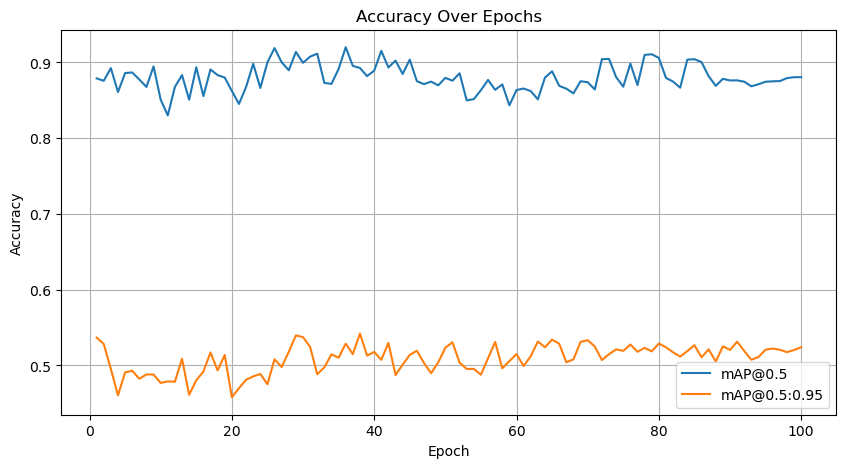

In [55]:
# Find the most recent training log directory
log_dir = max(glob('runs/detect/train*'), key = the_number_in_the_string)

# Load the training results
results = pd.read_csv(os.path.join(log_dir, 'results.csv'))
results.columns = results.columns.str.strip()  # Remove any leading/trailing whitespace from column names

# Extract epochs and accuracy metrics
epochs = results.index + 1  # Epochs are zero-indexed, so add 1
mAP_0_5 = results['metrics/mAP50(B)']  # Mean Average Precision at IoU=0.5
mAP_0_5_0_95 = results['metrics/mAP50-95(B)']  # Mean Average Precision at IoU=0.5:0.95

# Plot the accuracy over epochs
plt.figure(figsize=(10, 5))
plt.plot(epochs, mAP_0_5, label='mAP@0.5')
plt.plot(epochs, mAP_0_5_0_95, label='mAP@0.5:0.95')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [57]:
# Save the trained model
model.save('best_numberplatedetection.pt')

### Testing the model

In [60]:
def run(path_test_car):
    """
    Predicts and plots the bounding boxes on the given test image using the trained YOLO model.
    Also performs OCR on the detected bounding boxes to extract text.a
    """
    # Perform prediction on the test image using the model
    results = model.predict(path_test_car, device='cpu')

    # Load the image using OpenCV
    image = cv2.imread(path_test_car)
    # Convert the image from BGR (OpenCV default) to RGB (matplotlib default)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Extract the bounding boxes and labels from the results
    for result in results:
        for box in result.boxes:
            # Get the coordinates of the bounding box
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            # Get the confidence score of the prediction
            confidence = box.conf[0]

            # Draw the bounding box on the image
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            # Draw the confidence score near the bounding box
            cv2.putText(image, f'{confidence*100:.2f}%', (x1, y1 - 10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

            # Crop the bounding box from the image for OCR
            roi = image[y1:y2, x1:x2]

    # Plot the image with bounding boxes
    plt.imshow(image)
    plt.axis('off')  # Hide the axis
    plt.show()  # Display the image

In [62]:
print(test)

                       img_path  xmin  xmax  ymin  ymax  img_w  img_h
425  archive\images\Cars425.png   211   301   103   132    500    232
75    archive\images\Cars75.png   209   218   196   201    400    248
181  archive\images\Cars181.png    69   128   195   209    225    400
30    archive\images\Cars30.png   155   200   169   182    400    240
364  archive\images\Cars364.png    61   115   140   167    400    242
408  archive\images\Cars408.png   160   187   217   228    400    267
253  archive\images\Cars253.png    25    64   124   137    400    210
155  archive\images\Cars155.png   150   203   177   190    400    267
168  archive\images\Cars168.png    82   137    95   125    400    225
415  archive\images\Cars415.png   133   261   157   192    400    300
152  archive\images\Cars152.png    92   199   258   284    467    300
70    archive\images\Cars70.png   179   213   115   133    400    226
203  archive\images\Cars203.png   116   271   112   165    400    267
335  archive\images\


image 1/1 C:\Documents\Intel Unnati\Final\archive\images\Cars203.png: 224x320 1 license_plate, 58.6ms
Speed: 0.0ms preprocess, 58.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 320)


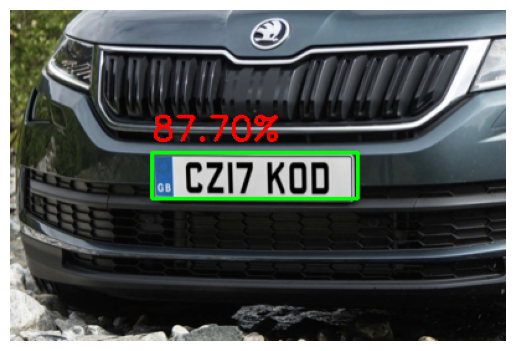

In [66]:
run(test.iloc[12].img_path)


image 1/1 C:\Documents\Intel Unnati\Final\archive\images\Cars287.png: 288x320 1 license_plate, 41.9ms
Speed: 0.0ms preprocess, 41.9ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 320)


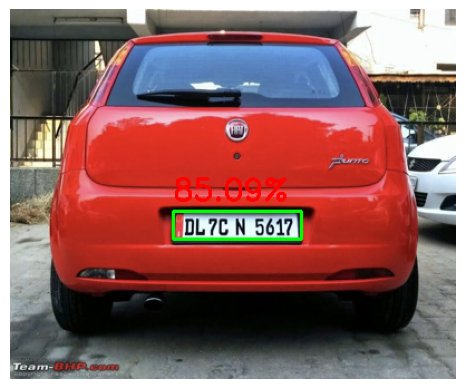

In [68]:
run(test.iloc[20].img_path)


image 1/1 C:\Documents\Intel Unnati\Final\archive\images\Cars198.png: 256x320 1 license_plate, 40.8ms
Speed: 0.0ms preprocess, 40.8ms inference, 0.0ms postprocess per image at shape (1, 3, 256, 320)


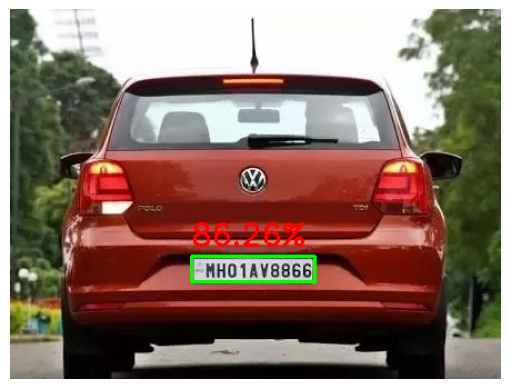

In [70]:
run(test.iloc[25].img_path)


image 1/1 C:\Documents\Intel Unnati\Final\archive\images\Cars126.png: 256x320 1 license_plate, 29.5ms
Speed: 1.0ms preprocess, 29.5ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 320)


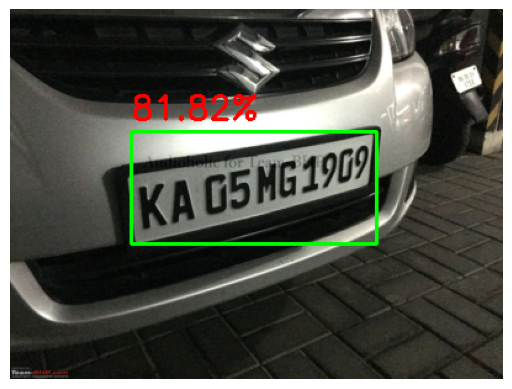

In [72]:
run(test.iloc[30].img_path)